# 1. Import the required libraries

In [1]:
# Standard code libraries
import os
import pandas as pd
import ipywidgets as widgets
import matplotlib.pyplot as plt

# Custom code libraries from ReSurfEMG
from resurfemg.data_connector.config import Config
from resurfemg.data_connector.file_discovery import find_files, find_folders
from resurfemg.pipelines.ipy_widgets import file_select
from resurfemg.data_connector.adicht_reader import AdichtReader
from resurfemg.data_connector.tmsisdk_lite import Poly5Reader
from resurfemg.data_connector.data_classes import EmgDataGroup, VentilatorDataGroup

config = Config(verbose=True)

%matplotlib widget

Loaded config from:
 C:\Users\WarnaarRSP/.resurfemg/config.json

The following paths were configured:
-------------------------------------------------------------------------------
 Name           	Path                                              
-------------------------------------------------------------------------------
 root           	C:\Users\WarnaarRSP\Repos\ReSurfEMG\resurfemg_addict\not_pushed
 output_data    	C:\Users\WarnaarRSP\Repos\ReSurfEMG\resurfemg_addicht\not_pushed\output_data
 patient_data   	P:\TNW\CRPH\Projects\2021_Warnaar_TOPSPIN_studie\4_Patient_data\1_RAW
 resurfemg_root 	P:\TNW\CRPH\Projects\2021_Warnaar_TOPSPIN_studie  
 preprocessed_data	C:\Users\WarnaarRSP\Repos\ReSurfEMG\resurfemg_addicht\not_pushed\preprocessed_data
 simulated_data 	C:\Users\WarnaarRSP\Repos\ReSurfEMG\resurfemg_addicht\not_pushed\simulated_data
 test_data      	C:\Users\WarnaarRSP\Repos\ReSurfEMG\resurfemg_addict\test_data


## 2. Load sEMG test data

In [2]:
# For the test data:
base_path = config.get_directory('resurfemg_root')
dirs = find_folders(base_path)

folder_dropdown = widgets.Dropdown(
    options=dirs['destination'].tolist(),
    description='Folder:',
    disabled=False,
    value=dirs['destination'].iloc[-1]
)
display(folder_dropdown)

Dropdown(description='Folder:', index=5, options=('4_Patient_data', '1_Study_approval_documentation', '3_Admin…

In [3]:
# File selection
folder_path = os.path.join(base_path, folder_dropdown.value)
files = find_files(
    base_path=folder_path,
    file_name_regex='*',
    extension_regex='adicht',
    folder_levels=None,
    verbose=False
)
button_list = file_select(
    files=files,
    folder_levels=['files'],
    default_value_select=None,
    default_idx_select=[0])

interactive(children=(Dropdown(description='files:', options=('emg_exper 2.adicht', 'emg_exper 3.adicht', 'oli…

Help on method get_data in module adi.read:

get_data(record_id, start_sample=None, stop_sample=None) method of adi.read.Channel instance



In [4]:
# Load the EMG from the selected folders:
emg_file_chosen = os.path.join(folder_path, *[btn.value for btn in button_list])

data_emg = AdichtReader(emg_file_chosen)
# data_emg_samples = data_emg.samples[:data_emg.num_samples]
# fs_emg = data_emg.sample_rate
data_emg.print_metadata()    # Extracts and provides a tabular overview of the channels, samples, records, sampling rates, units, and time step.

Available Channels and Metadata:
+------------+-----------+---------+-----------------------------+--------------------------------+--------------------------------+--------------------------+
| Channel ID | Name      | Records |           Samples           |       Sampling Rate (Hz)       |          timestep (s)          |          Units           |
+------------+-----------+---------+-----------------------------+--------------------------------+--------------------------------+--------------------------+
|     1      | Channel 1 |    4    | 15615, 201412, 28483, 46799 | 2000.0, 2000.0, 2000.0, 2000.0 | 0.0005, 0.0005, 0.0005, 0.0005 | ['µV', 'µV', 'µV', 'µV'] |
|     2      | Channel 2 |    4    | 15615, 201412, 28483, 46799 | 2000.0, 2000.0, 2000.0, 2000.0 | 0.0005, 0.0005, 0.0005, 0.0005 | ['mV', 'mV', 'mV', 'mV'] |
+------------+-----------+---------+-----------------------------+--------------------------------+--------------------------------+--------------------------+


[{'id': 1,
  'name': 'Channel 1',
  'records': 4,
  'samples': [15615, 201412, 28483, 46799],
  'sampling_rate': [2000.0, 2000.0, 2000.0, 2000.0],
  'time_step': [0.0005, 0.0005, 0.0005, 0.0005],
  'units': ['µV', 'µV', 'µV', 'µV']},
 {'id': 2,
  'name': 'Channel 2',
  'records': 4,
  'samples': [15615, 201412, 28483, 46799],
  'sampling_rate': [2000.0, 2000.0, 2000.0, 2000.0],
  'time_step': [0.0005, 0.0005, 0.0005, 0.0005],
  'units': ['mV', 'mV', 'mV', 'mV']}]

In [18]:
# Select the channels and records to be extracted
select_channel_idxs = [0, 1]
record_idx = 2

# # Resample channels if needed
# # In this example, Ch 1 would be resampled to 2000 Hz
# resample_channels_dict={       
#     1: 2000,                          
# }

# Extract the data
data_emg_df, fs_emg = data_emg.extract_data(
    channel_idxs=select_channel_idxs,
    record_idx=record_idx,
    resample_channels=None,
)

# # Alternatively, the data can be resampled after the extraction
# ch_1_resampeled_df = data_emg.resample_channel(
#     channel_id= 1,record_id= 1,target_rate= 2000)

# # Optionally, select a specific time range from the DataFrame
# start_time = pd.Timedelta('2 minutes 20 seconds')  # safety margin of 10seconds
# end_time = pd.Timedelta('2 minutes 30 seconds')
# selected_data_df = data_emg_df[(data_emg_df.index >= start_time) & (data_emg_df.index <= end_time)]
# y_emg   = selected_data_df.to_numpy().T

# # get the labels and units of the selected channels
y_emg = data_emg_df.to_numpy().T
labels  = data_emg.get_labels(select_channel_idxs)
units   = data_emg.get_units(select_channel_idxs, record_idx)

In [19]:
y_emg.shape

(2, 201412)

In [8]:
# Store the EMG data in a group of TimeSeries objects
t_emg = [i/fs_emg for i in range(len(y_emg[0, :]))]
emg_timeseries = EmgDataGroup(
    y_emg,
    fs=fs_emg,
    labels=labels,
    units=units)

No ECG channel detected. Set ECG channel index with `EmgDataGroup.set_ecg_idx(arg)` method.


In [9]:
emg_timeseries.set_ecg_idx(0)

# 3. Pre-process the data

In [10]:
# Filter
emg_timeseries.run('filter_emg')

In [11]:
# # Through gating
# emg_timeseries.gating(overwrite=True)
emg_timeseries.run('gating', overwrite=True)

# # Through wavelet denoising
# emg_timeseries.run('wavelet_denoising', overwrite=True)
# # emg_timeseries.run('wavelet_denoising', n=8, fixed_threshold=8.0, overwrite=True)

Set ECG channel used for ECG removal.


In [12]:
# Calculate the envelope of the signal
# emg_timeseries.run('envelope')
emg_timeseries.run('envelope', ci_alpha=0.05)
# emg_timeseries.run('envelope', env_type='arv')
# emg_timeseries.run('envelope', env_type='arv', ci_alpha=0.05)

In [13]:
# Calculate the baseline for the EMG envelopes and p_vent
emg_timeseries.run('baseline')
# vent_timeseries.run(
#     'baseline',
#     channel_idxs=[0],
#     signal_type='raw')

(np.float64(-0.39035000000000003),
 np.float64(8.19735),
 np.float64(0.0),
 np.float64(1.0))

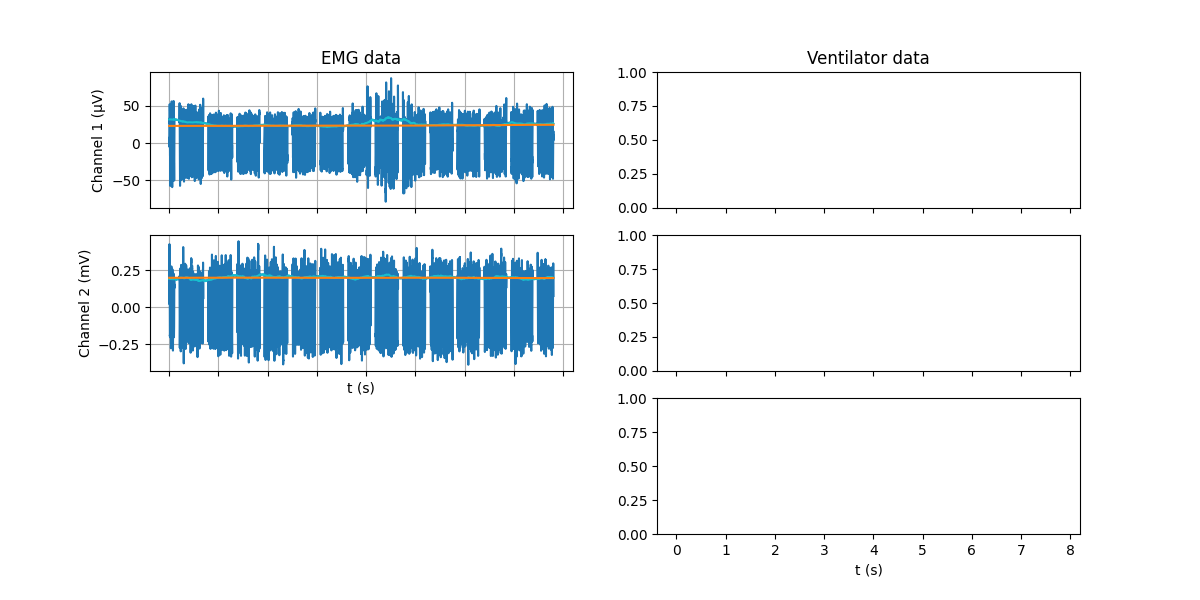

In [14]:
# Plot the raw data with the envelope
# EMG data
fig, axis = plt.subplots(nrows=3, ncols=2, figsize=(12, 6), sharex=True)
axes_emg = axis[:2, 0]
colors = ['tab:cyan', 'tab:orange']
emg_timeseries.run(
    'plot_full', axes=axes_emg, signal_type='clean', baseline_bool=False)
emg_timeseries.run(
    'plot_full', axes=axes_emg, signal_type='env', colors=colors)

axes_emg[0].set_title('EMG data')
axes_emg[-1].set_xlabel('t (s)')

# Ventilator data data
axes_vent = axis[:, 1]
# vent_timeseries.run('plot_full', axes=axes_vent)
axes_vent[0].set_title('Ventilator data')
axes_vent[-1].set_xlabel('t (s)')

axis[-1, 0].axis('off')

# axes_vent[-1].set_xlim([370, 410])